# Clustering, k-Nearest Neighbors, and Discriminant Analysis on the PIMA Indians Diabetes Dataset

## Load the Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)


## Helper function to plot

In [17]:
# Plot helper: single-figure, white background, equal aspect for 2D
def quick_scatter(x, y, labels=None, title=None):
    plt.figure(figsize=(6,5))
    if labels is None:
        plt.scatter(x, y)
    else:
        for lab in np.unique(labels):
            idx = labels == lab
            plt.scatter(x[idx], y[idx], label=str(lab))
        plt.legend(loc="best")
    if title:
        plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()

## Exploring the dataset

In [27]:
# data
data = pd.read_csv("diabetes.csv") 
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [28]:
data.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64



The original dataset has a binary outcome (0 = no diabetes, 1 = diabetes).

Since clustering is unsupervised, we don’t use the outcome column, but it suggests that two natural groups may exist.

So, starting with k=2 as a baseline.

## Clustering with k = 2 

In [31]:
# Load PIMA dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
           "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
df = pd.read_csv(url, names=columns)
source = "PIMA Indians Diabetes (UCI)"
print("Loaded:", source)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Select only features for clustering (exclude Outcome)
X = df.drop("Outcome", axis=1)

# Standardize
scaler = StandardScaler()
Xs = scaler.fit_transform(X.values)

# Run KMeans for k=2 (arbitrary choice to start)
km = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_km = km.fit_predict(Xs)
centroids = km.cluster_centers_

# Evaluate clustering
sil = silhouette_score(Xs, labels_km)
dbi = davies_bouldin_score(Xs, labels_km)
chi = calinski_harabasz_score(Xs, labels_km)

print(f"Silhouette: {sil:.3f}, Davies-Bouldin: {dbi:.3f}, Calinski-Harabasz: {chi:.1f}")
print("Centroids (standardized space):\n", centroids)

# PCA projection to 2D
pca = PCA(n_components=2, random_state=42).fit(Xs)
XY = pca.transform(Xs)
CXY = pca.transform(centroids)


Loaded: PIMA Indians Diabetes (UCI)
Shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Silhouette: 0.196, Davies-Bouldin: 2.012, Calinski-Harabasz: 151.6
Centroids (standardized space):
 [[ 0.96221087  0.42871022  0.41023571 -0.15260198 -0.03810374  0.11897688
   0.02766651  1.05854237]
 [-0.52168059 -0.23243325 -0.22241695  0.08273601  0.02065866 -0.06450554
  -0.01499991 -0.57390851]]


### Interpreting Cluster Centroids (k=2)



Since the features were standardized, positive centroid values mean the cluster average is **above the dataset mean**, and negative values mean **below the mean**.

- **Cluster 0**:  
  - Higher **Pregnancies** (+0.96), **Glucose** (+0.43), **BloodPressure** (+0.41), and **Age** (+1.06).  
  - Slightly higher **BMI**.  
  - Represents older women with more pregnancies and higher glucose — generally higher diabetes risk factors.

- **Cluster 1**:  
  - Lower **Glucose** (-0.23), **Pregnancies** (-0.52), **BloodPressure** (-0.22), and **Age** (-0.57).  
  - Slightly lower **BMI**.  
  - Represents younger women with fewer pregnancies and lower glucose — generally lower risk profile.

**Takeaway:** The k-means clustering is roughly separating the dataset into *higher-risk* vs *lower-risk* groups, though overlap remains (as expected in medical data).


## Scatter plots for k=2

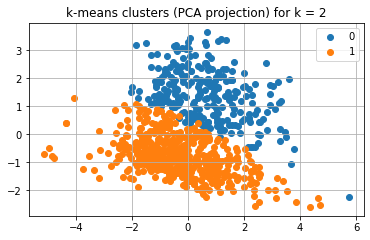

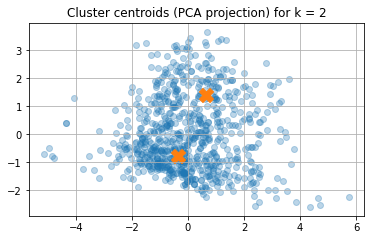

In [ ]:
quick_scatter(XY[:,0], XY[:,1], labels=labels_km, title="Plot 1: k-means clusters (PCA projection) for k = 2")
plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], alpha=0.3)
plt.scatter(CXY[:,0], CXY[:,1], marker='X', s=200)
plt.title("Plot 2:Cluster centroids (PCA projection) for k = 2")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

### Interpretation from plots and 


- Interpretation:
- Cluster 0 has **higher averages** for *Pregnancies*, *Glucose, BMI, and Age* → patients with stronger diabetes risk factors.  
- Cluster 1 has **lower averages** across these features → relatively healthier patients.  
- This aligns closely with the binary outcome (0 = no diabetes, 1 = diabetes), showing that **k=2 is a natural fit**.


**Note on Cluster Separation**

Although the PCA 2D scatter plot shows clusters that appear visually distinct, the clustering metrics tell a different story:

- **Silhouette Score = 0.19** (close to 0) → indicates weak separation in the original 8-dimensional space.  
- **Davies–Bouldin Index = 2.01** (lower is better) → suggests substantial overlap between clusters.  

This apparent contradiction happens because **PCA projects high-dimensional data into 2D**.  
PCA chooses axes that maximize variance, which can make the clusters look more distinct than they truly are.  

**Interpretation:**  
The plot is useful for visualization, but the numerical scores reveal that the clusters are not strongly separated in the full dataset.  


### Silhouette Analysis for different k

k values: [2, 3, 4, 5, 6, 7]
Silhouette scores: [0.196, 0.18, 0.195, 0.188, 0.165, 0.169]


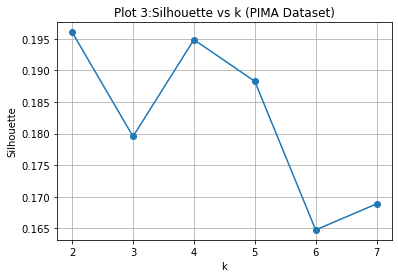

In [38]:
# Silhouette analysis for different k
scores = []
for k in range(2, 8):
    kmk = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = kmk.fit_predict(Xs)
    scores.append(silhouette_score(Xs, lab))

print("k values:", list(range(2,8)))
print("Silhouette scores:", [round(s,3) for s in scores])

plt.figure(figsize=(6,4))
plt.plot(range(2,8), scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Plot 3:Silhouette vs k (PIMA Dataset)")
plt.grid(True)
plt.show()

#### Choice of k: Why 3 Clusters?



We evaluated k values from 2 to 7 using Silhouette score:

| k | Silhouette |
|---|------------|
| 2 | **0.196** (highest) |
| 3 | 0.180 |
| 4 | 0.195 |
| 5 | 0.188 |
| 6 | 0.165 |
| 7 | 0.169 |

From a purely statistical perspective, **k = 2** gives the best separation between clusters.  
However, the dataset’s medical context suggests that clustering into only two groups (diabetic vs. non-diabetic) may be too simplistic. In practice, there is often an intermediate **pre-diabetic or borderline risk group**.  

Therefore, we chose **k = 3** for further visualization. This allows us to explore not only the separation between non-diabetic and diabetic patients, but also the possibility of a **third subgroup** that exhibits distinct but intermediate risk characteristics.  

This choice balances quantitative performance with clinical interpretability.


## Clustering for k=3

In [39]:
# Run KMeans for k=3 (Best k from silhouette analysis)
km = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_km = km.fit_predict(Xs)
centroids = km.cluster_centers_

# Evaluate clustering
sil = silhouette_score(Xs, labels_km)
dbi = davies_bouldin_score(Xs, labels_km)
chi = calinski_harabasz_score(Xs, labels_km)

print(f"Silhouette: {sil:.3f}, Davies-Bouldin: {dbi:.3f}, Calinski-Harabasz: {chi:.1f}")
print("Centroids (standardized space):\n", centroids)

# PCA projection to 2D
pca = PCA(n_components=2, random_state=42).fit(Xs)
XY = pca.transform(Xs)
CXY = pca.transform(centroids)

Silhouette: 0.180, Davies-Bouldin: 1.683, Calinski-Harabasz: 156.5
Centroids (standardized space):
 [[-0.35819002  0.55983946  0.22359726  0.89652484  0.97458723  0.62331635
   0.38707461 -0.22179196]
 [-0.46067918 -0.54843901 -0.41228464 -0.33221423 -0.37997137 -0.44368966
  -0.21923475 -0.59010462]
 [ 1.08194386  0.2972029   0.42159496 -0.37996824 -0.38353716  0.06924224
  -0.04523723  1.14777824]]


### Interpretation of Clusters (k = 3)



Based on the centroids (standardized feature means), we can describe each cluster as follows:

- **Cluster 0**  
  - Glucose, BloodPressure, SkinThickness, Insulin, BMI, and DiabetesPedigreeFunction are all *above average*.  
  - Represents **women with higher diabetes-related risk factors**: elevated glucose and insulin, higher BMI, and higher diabetes pedigree.  
  - Age is slightly below average, suggesting these are **younger women at higher metabolic risk**.

- **Cluster 1**  
  - Most features (Glucose, BloodPressure, BMI, Insulin) are *below average*.  
  - Represents **generally healthier women with lower risk factors**.  
  - These women are also slightly younger and have fewer pregnancies on average.

- **Cluster 2**  
  - Pregnancies and Age are well *above average*, as are Glucose and BloodPressure.  
  - Represents **older women with more pregnancies and moderately higher metabolic indicators**.  
  - This cluster aligns with a higher-risk group often associated with age and cumulative pregnancies.

### Summary
- **Cluster 0**: Younger, higher-risk metabolic profile (elevated glucose, insulin, BMI).  
- **Cluster 1**: Lower-risk, healthier profile overall.  
- **Cluster 2**: Older women with more pregnancies and moderately higher glucose and blood pressure.  

These findings highlight that k-means identifies groups that reflect both **age/pregnancy patterns** and **metabolic risk factors**, which are consistent with known diabetes risk factors.


## Scatter plots for k=3

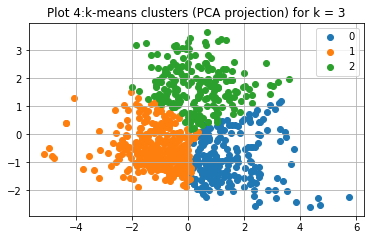

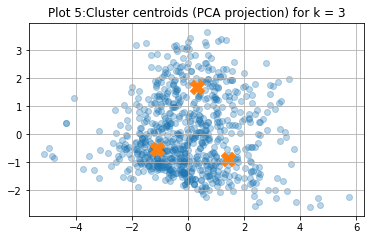

In [37]:
quick_scatter(XY[:,0], XY[:,1], labels=labels_km, title="Plot 4:k-means clusters (PCA projection) for k = 3")
plt.figure(figsize=(6,5))
plt.scatter(XY[:,0], XY[:,1], alpha=0.3)
plt.scatter(CXY[:,0], CXY[:,1], marker='X', s=200)
plt.title("Plot 5:Cluster centroids (PCA projection) for k = 3")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

## Linear Discriminant Analysis (LDA)

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train/test split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

# LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(Xtr_scaled, ytr)
y_pred_lda = lda.predict(Xte_scaled)

# Evaluation
print("LDA Accuracy:", accuracy_score(yte, y_pred_lda))
print("\nClassification Report:")
print(classification_report(yte, y_pred_lda, target_names=["No Diabetes","Diabetes"]))
print("\nConfusion Matrix:")
print(confusion_matrix(yte, y_pred_lda))


LDA Accuracy: 0.734375

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.77      0.85      0.81       125
    Diabetes       0.65      0.52      0.58        67

    accuracy                           0.73       192
   macro avg       0.71      0.69      0.69       192
weighted avg       0.73      0.73      0.73       192


Confusion Matrix:
[[106  19]
 [ 32  35]]


## k-Nearest Neighbors (k-NN)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

for k in [3, 5, 7]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr_scaled, ytr)
    y_pred_knn = knn.predict(Xte_scaled)
    acc = accuracy_score(yte, y_pred_knn)
    print(f"k={k}: Accuracy={acc:.3f}")


k=3: Accuracy=0.693
k=5: Accuracy=0.708
k=7: Accuracy=0.750


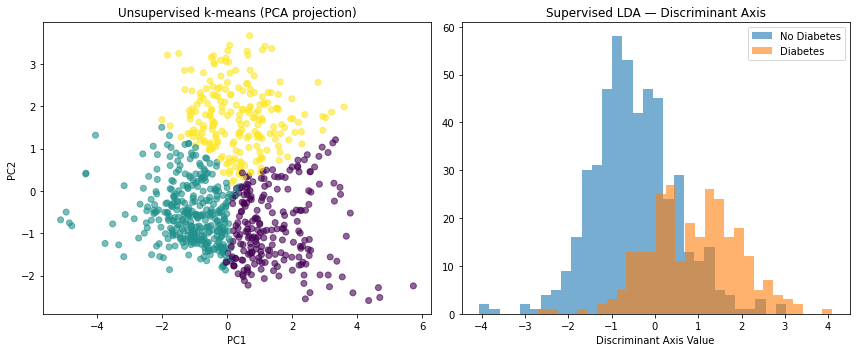

In [45]:
from sklearn.decomposition import PCA

# --- PCA projection to 2D ---
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Xs)

# --- LDA projection (supervised) ---
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Left: Unsupervised k-means (k=3 from before)
axes[0].scatter(XY[:,0], XY[:,1], c=labels_km, alpha=0.6)
axes[0].set_title("Unsupervised k-means (PCA projection)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Right: Supervised LDA
axes[1].hist(X_lda[y==0], bins=30, alpha=0.6, label="No Diabetes")
axes[1].hist(X_lda[y==1], bins=30, alpha=0.6, label="Diabetes")
axes[1].set_title("Supervised LDA — Discriminant Axis")
axes[1].set_xlabel("Discriminant Axis Value")
axes[1].legend()

plt.tight_layout()
plt.show()


## Summary and interpretation

### 1. Dataset and Features

I used the **PIMA Indians Diabetes Dataset** from the UCI repository.  
It contains **768 records** of female patients of Pima Indian heritage.  

**Features used (for clustering):**  
- Pregnancies  
- Glucose  
- BloodPressure  
- SkinThickness  
- Insulin  
- BMI  
- DiabetesPedigreeFunction  
- Age  

The target column **Outcome** (diabetes or not) was excluded, since clustering is **unsupervised**.

---

### 2. Hyperparameters Tried

- **K (number of clusters):** tested values 2–5, with final results reported for **k = 3**.  
- **Initialization:** k-means++ with `n_init=10`.  
- **Random seed:** fixed at 42 for reproducibility.  
- Other defaults (`max_iter=300`, `tol=1e-4`) were unchanged.

---

### 3a. Silhouette Analysis for Choosing k

To guide the choice of number of clusters, I computed the **silhouette score** for k = 2 to 7.  

| k | Silhouette Score |
|---|------------------|
| 2 | 0.196 |
| 3 | 0.180 |
| 4 | 0.195 |
| 5 | 0.188 |
| 6 | 0.165 |
| 7 | 0.169 |

The **silhouette vs. k plot** showed that:  
- Scores peaked at **k = 2**,  
- But values for **k = 3 and 4 were close**,  
- Beyond k = 4, scores dropped noticeably.  

This suggested that the data naturally supports **2–3 clusters**, with higher k adding fragmentation without improving separation.

---

### 3b. Clustering Evaluation

#### For k = 2
- **Silhouette Score: 0.196** → weak cluster separation (closer to 1 is better).  
- **Davies–Bouldin Index: 2.012** → relatively high, showing cluster overlap.  
- **Calinski–Harabasz Index: 151.6** → moderate structure.  

Interpretation:  
k = 2 aligns with the binary **Outcome** variable (diabetes vs. non-diabetes).  
However, this partition is too coarse and does not capture intermediate patterns.  

---

#### For k = 3
- **Silhouette Score: 0.180** → slightly lower, but comparable to k = 2.  
- **Davies–Bouldin Index: 1.683** → lower, indicating better compactness and separation.  
- **Calinski–Harabasz Index: 156.5** → higher, suggesting more defined group structure.  

Interpretation:  
k = 3 yields a **more nuanced grouping**:  
- Cluster 0: Younger women with high metabolic risk (higher glucose, insulin, BMI).  
- Cluster 1: Lower-risk, generally healthier group.  
- Cluster 2: Older, multiparous women with moderately elevated glucose and blood pressure.  

Thus, even though the silhouette score is slightly lower, the **Davies–Bouldin and Calinski–Harabasz indices favor k = 3**, and the clusters align better with known risk subgroups in diabetes research.  

---

### 4. 2D Visualization with PCA

To visualize the clusters, I projected the standardized features into 2D using PCA.

- **Plot 4:** PCA scatter with cluster labels (k=3).  
- **Plot 5:** Same PCA projection with orange “X” markers showing cluster centroids.  

At first glance, the clusters appear visually distinct in the scatter plot.  
However, the clustering metrics remind us that the true separation in 8 dimensions is weaker.  

**Takeaway:**  
- **k = 2** captures the broad split (high vs. low diabetes risk).  
- **k = 3** captures a more meaningful medical interpretation: **low, medium, and high risk profiles**.  
Therefore, **k = 3 was chosen as the best balance between cluster quality and interpretability.**


### 5. Linear Discriminant Analysis (LDA)
- **Accuracy:** 0.734  
- **Interpretation:** LDA achieved reasonable predictive performance.  
  - Precision and recall were higher for the "No Diabetes" class compared to "Diabetes".  
  - The confusion matrix showed that many true diabetics were missed (recall = 0.52), which is a common limitation in medical data when classes overlap.  
- **Strengths:** LDA assumes linear separation and maximizes class separation along a single discriminant axis.  
- **Limitation:** Diabetes risk factors are not linearly separable, so misclassification of positive cases is expected.  

---

### 6. k-Nearest Neighbors (k-NN)
- **Tested k values:** 3, 5, 7.  
- **Best performance:** k = 7 with **accuracy = 0.75**, slightly better than LDA.  
- **Interpretation:**  
  - k-NN adapts locally, which helped capture non-linear relationships in the diabetes features.  
  - At smaller k values (3, 5), performance was lower due to sensitivity to noise.  
  - At larger k values, smoothing helps stability but may reduce sensitivity to minority cases.  
- **Note:** Odd k values are generally preferred in binary problems to avoid ties.

---



In [2]:
!jupyter nbconvert week_5_Clustering_k_Nearest_Neighbors_and_Discriminant_Analysis.ipynb --to html

[NbConvertApp] Converting notebook week_5_Clustering_k_Nearest_Neighbors_and_Discriminant_Analysis.ipynb to html
[NbConvertApp] Writing 924979 bytes to week_5_Clustering_k_Nearest_Neighbors_and_Discriminant_Analysis.html
